# Lyft Bike Share Data Bay Area

Vsualizations of Lyft bike share usage in 2020. See [Sources](http://localhost:8888/notebooks/Desktop/Lyft%20Bike%20Project.ipynb#Sources) for details on data and processes.

### Research Questions
1. How has behavior changed pre/post Covid?
2. Are there notable differences between members and not?
3. What are the most popular stations that trips originate from? Dos this differ between members and casual riders?

### Things to Come Back to
* Drop bad cells and update queries (NANs)
* Ensuring no dupes across CSV files
* Getting data from website
* Putting shape files somewhere publicly accessible
* Getting data April - forward

#### Things Complete
* Start date as own variable, not overwritten
* Cleaning up April data in March file
* Cleaning up (0,0) rides
* Consolidating data clean up
* Re-indexing joined files
* Querying by condition (rides by day where covid=1, most popular station where member)
* Mapping points to city bounds


In [3]:
## Imports

import pandas as pd
import descartes
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import numpy as np
from shapely.geometry import Point, polygon
import matplotlib.colors as colors

%matplotlib inline

In [4]:
## Read in all the CSVs. For Proof of Concept
## From Downloads not Web. For Proof of Concept
## Excluding Data April 2020 forward because column names are different

df = pd.concat([pd.read_csv(f) for f in glob.glob('/Users/kailinkoch/Downloads/2020*-baywheels-tripdata.csv')], ignore_index=True)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Cleaning Up Data Set

* Small number (24 records, ~0.003% of total records) of records are from the `16th St Fleet Depot`. These records have a coordinate of (0,0) and it is not clear that these are legitimate rides. As such, I am updating them to `NaN` to ensure the proper display of the chart.
* Small number of records (1792 records, ~0.2% of total records) from the wrong month. Putting in basic logic to remove April records given we haven't imported April file
* Changing confusing nomenclature of users.

In [5]:
## Identify number of records where starting coordinates = (0,0)
min_latitude = min(df.start_station_latitude)
max_longitude = max(df.start_station_longitude)
print(f'the min latitude is {min_latitude}')
print(f'the max longitude is {max_longitude}')
print(pd.DataFrame.count(df.loc[df['start_station_latitude']== 0.0]))
pd.DataFrame.count(df.loc[df['start_station_longitude']== 0.0])

the min latitude is 0.0
the max longitude is 0.0
duration_sec               24
start_time                 24
end_time                   24
start_station_id           24
start_station_name         24
start_station_latitude     24
start_station_longitude    24
end_station_id              0
end_station_name            0
end_station_latitude       24
end_station_longitude      24
bike_id                    24
user_type                  24
rental_access_method       24
dtype: int64


duration_sec               24
start_time                 24
end_time                   24
start_station_id           24
start_station_name         24
start_station_latitude     24
start_station_longitude    24
end_station_id              0
end_station_name            0
end_station_latitude       24
end_station_longitude      24
bike_id                    24
user_type                  24
rental_access_method       24
dtype: int64

In [6]:
## Updating (0,0) entries to Nan
df.loc[df['start_station_latitude'] == 0,'start_station_latitude'] = np.nan
df.loc[df['start_station_longitude'] == 0,'start_station_longitude'] = np.nan

In [203]:
## Removing April Entries

# df.loc[df['start_time']>= '04/01/20', 'start_station_latitude'] = np.nan
# df.loc[df['start_time']>= '04/01/20', 'start_station_longitude'] = np.nan

In [7]:
## Rename 2 user types because it's very confusing that a 'customer' is a casual one-off purchaser!

df.loc[df['user_type'] == 'Subscriber','user_type'] = 'annual_subscriber'
df.loc[df['user_type'] == 'Customer','user_type'] = 'casual_rider'

In [8]:
## Confirming the above was done properly

min_latitude =  min(df.start_station_latitude)
max_longitude = max(df.start_station_longitude)
print(f'the min latitude is {min_latitude}')
print(f'the max longitude is {max_longitude}')

the min latitude is 37.2530496667
the max longitude is -121.8070486667


### Adding New Variables for Aggregation
* Date - so that we can see total records by date
* City - so that we can see behavior change on the county level rather than bike dock level
* Coordinates - not yet as `POINT` object, just as a tuple so we can use to identify if point in city
* Covid - binary variable for pre/post 3/16 (when shelter in place went into effect in Bay Area

In [9]:
##  Adding 2 new fields to the DF: a day variable and a city variable

df.insert(loc=14, column = 'start_date',           value = 'datetime')
df.insert(loc=14, column = 'coordinates_nongeom2', value = zip)
df.insert(loc=14, column = 'start_month',          value = 'datetime')
df.insert(loc=14, column = 'covid',                value = int)
#df.insert(loc=14, column = 'city',                 value = str)

In [10]:
## Populating tuple for coordinates (NOT yet in geometry form)

df['coordinates_nongeom2'] = [(xy) for xy in zip(df["start_station_longitude"], df["start_station_latitude"])]

In [11]:
## Populating basic date fields 

df["start_time"]  = pd.to_datetime(df["start_time"])
df["start_date"]  = df["start_time"].dt.date
df["start_month"] = df["start_time"].dt.month

In [12]:
## Make a Binary Pre-Post Covid Variable (Shelter in Place takes effect on 3/16)

df.loc[df['start_time'] >= '3/16/20', 'covid'] = 1
df.loc[df['start_time'] <  '3/16/20', 'covid'] = 0
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method,covid,start_month,coordinates_nongeom2,start_date
0,83118,2020-01-31 15:23:47.733,2020-02-01 14:29:06.2630,400.0,Buchanan St at North Point St,37.804272,-122.433537,400.0,Buchanan St at North Point St,37.804272,-122.433537,13052,casual_rider,NaN,0,1,"(-122.4335369468, 37.8042720199)",2020-01-31
1,68239,2020-01-31 15:40:31.616,2020-02-01 10:37:51.0000,99.0,Folsom St at 15th St,37.767037,-122.415443,99.0,Folsom St at 15th St,37.767037,-122.415443,12235,annual_subscriber,NaN,0,1,"(-122.41544250000001, 37.7670373)",2020-01-31
2,55407,2020-01-31 17:48:16.635,2020-02-01 09:11:44.3170,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,12822,casual_rider,NaN,0,1,"(-122.24967990000002, 37.808847899999996)",2020-01-31
3,54929,2020-01-31 17:53:03.413,2020-02-01 09:08:32.6340,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,11705,casual_rider,NaN,0,1,"(-122.24967990000002, 37.808847899999996)",2020-01-31
4,55700,2020-01-31 17:12:33.460,2020-02-01 08:40:53.6460,12.0,Pier 1/2 at The Embarcadero,37.796389,-122.394586,371.0,Lombard St at Columbus Ave,37.802746,-122.413579,3673,casual_rider,NaN,0,1,"(-122.3945855, 37.796389399999995)",2020-01-31


## Basic Info Pre-COVID
* Run Pre Covid (Covid==0, Jan - March 16, when shelter in place began in bay area)
* Breakdown of annual subscribers vs casual riders
* Most popular stations
* Rides by day of the Week

In [13]:
## How many rides in this data set? How many are pre-COVID?

df_precovid = df[df['covid'] == 0]
total_rides = (df['user_type'].count())
print(f'There are {total_rides} total rides in this data set')

precovid_rides = (df_precovid['user_type'].count())
print(f'There are {precovid_rides} rides from Pre-COVID in this data set')


There are 905007 total rides in this data set
There are 865018 rides from Pre-COVID in this data set


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


Text(0, 0.5, '')

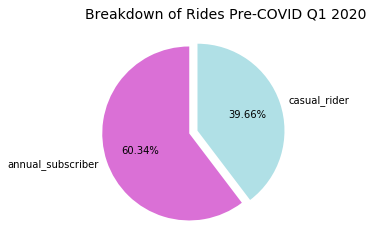

In [14]:
## What is the breakdown of users (casual users vs. annual subscriber)

df_precovid['user_type'].value_counts().plot(kind ='pie', startangle=90, explode = [0.05,0.05], colors = ('orchid', 'powderblue'), autopct='%.2f%%',radius = 1)
plt.title('Breakdown of Rides Pre-COVID Q1 2020', fontsize = 14, loc = 'left')
plt.axes().set_ylabel('')

Text(0.5, 1.0, 'BayWheels Initiated Rides by Day of Week Pre-COVID Q1 2020')

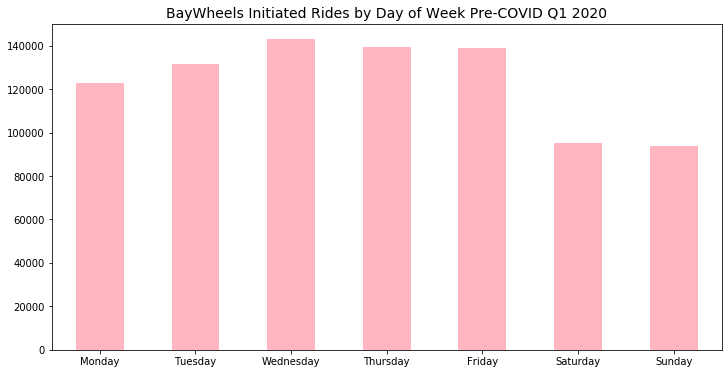

In [15]:
## Rides by Day of Week (PreCovid, 0 == Monday, 6 == Sunday)

## df_precovid_casual_riders      = df_precovid[df_precovid['user_type'] == 'casual_rider']
## df_precovid_annual_subscribers = df_precovid[df_precovid['user_type'] == 'annual_subscriber']

dayofweek = df_precovid["start_time"].dt.weekday.value_counts().sort_index()
## dayofweek_annual_subscribers = df_precovid_annual_subscribers["start_time"].dt.weekday.value_counts().sort_index()
## dayofweek_casual_riders = df_precovid_casual_riders["start_time"].dt.weekday.value_counts().sort_index()

fig,ax = plt.subplots(figsize=(12,6))
dayofweek_figure = dayofweek.plot(kind = 'bar', color = 'lightpink')

plt.Axes.set_xticklabels(dayofweek_figure,labels = ['Monday', 'Tuesday','Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation = 0)
plt.title('BayWheels Initiated Rides by Day of Week Pre-COVID Q1 2020', fontsize = 14, loc ='center')

## Same pattern for casual vs. annual

In [16]:
## Most Popular Stations 

top_stations=pd.DataFrame(df_precovid.groupby(["start_station_latitude", "start_station_longitude", "start_station_name"],as_index=False).size().sort_values(ascending=False).head(10))
top_stations.reset_index(inplace=True)
top_stations.rename({0:'number_of_rides'}, axis='columns', inplace=True)
top_stations
## Mostly the same top stations between casual and annual

,start_station_latitude,start_station_longitude,start_station_name,number_of_rides
0,37.776619,-122.417385,Market St at 10th St,7302
1,37.776598,-122.395282,San Francisco Caltrain (Townsend St at 4th St),7217
2,37.775880,-122.393170,Berry St at 4th St,6346
3,37.789756,-122.394643,Howard St at Beale St,5203
4,37.794497,-122.394838,Market St at Steuart St,4848
5,37.786375,-122.404904,Powell St BART Station (Market St at 4th St),4648
6,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,4569
7,37.783899,-122.408445,Powell St BART Station (Market St at 5th St),4455
8,37.789625,-122.400811,Montgomery St BART Station (Market St at 2nd St),4313
9,37.764478,-122.402570,Rhode Island St at 17th St,3235


## Ride Behavior around COVID

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

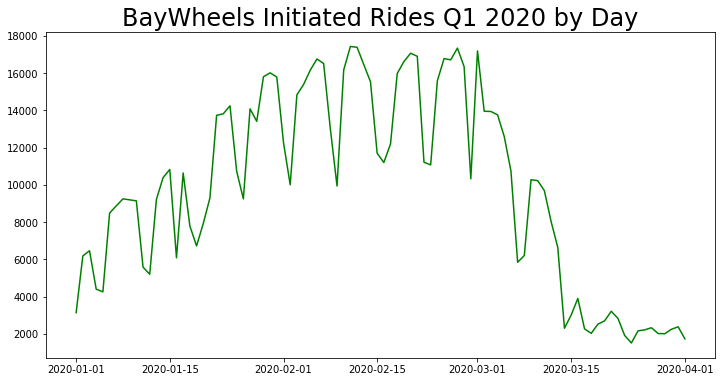

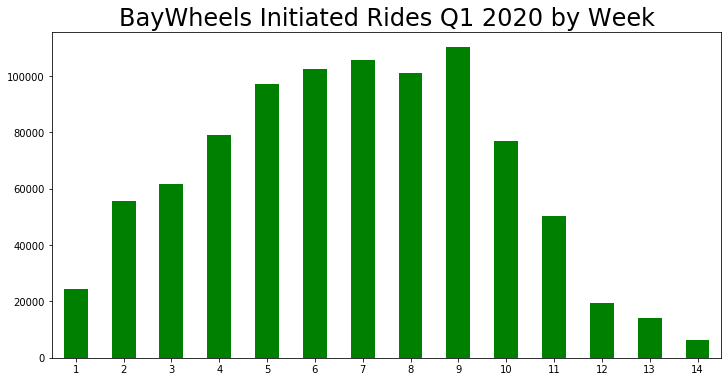

In [17]:
## Rides by Day and Month in Q1

rides_by_day=df['start_date'].value_counts()
fig,ax = plt.subplots(figsize=(12,6))
rides_by_day.plot(ax=ax, color='green')
plt.title('BayWheels Initiated Rides Q1 2020 by Day', fontsize=24, loc='center')

rides_by_week=df['start_time'].dt.week.value_counts().sort_index()
fig,ax = plt.subplots(figsize=(12,6))
rides_by_week_figure=rides_by_week.plot(ax=ax, kind='bar', color='green')
plt.title('BayWheels Initiated Rides Q1 2020 by Week', fontsize=24, loc='center')
plt.xticks(rotation=0)

# Same pattern for casual vs annual

Text(0.5, 1.0, 'BayWheels Initiated Rides March 2020')

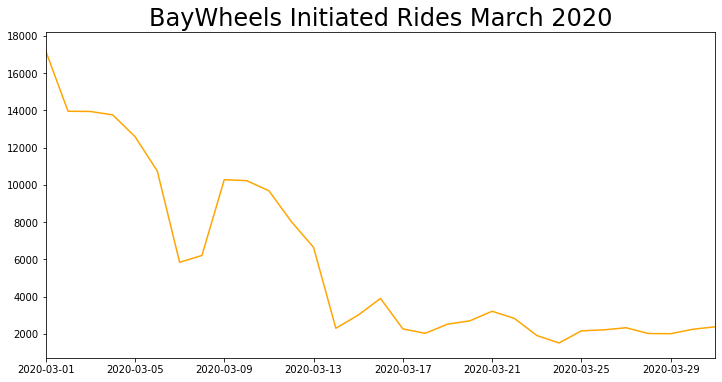

In [18]:
## Rides by day in March?
fig,ax = plt.subplots(figsize=(12,6))
rides_by_day.plot(ax=ax,kind='line', xlim= ['3/1/20', '3/31/20'], color='orange')
plt.title('BayWheels Initiated Rides March 2020', fontsize=24, loc='center')

### Adding the Shape Files
* Pulled in 3 options - bay area, counties and cities
* Cities map closest to the Bay Wheels footprint, which is centered in SF, Oakland and SJ

In [19]:
bay_area = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7hs4j-shapefile/s7hs4j.shp')

In [20]:
bay_area_counties = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7hs4j-shapefile (1)/s7hs4j.shp')

In [21]:
bay_area_cities = gpd.read_file('/Users/kailinkoch/Downloads/stanford-vj593xs7263-shapefile/vj593xs7263.shp')

In [22]:
bay_area_zips = gpd.read_file('/Users/kailinkoch/Downloads/ark28722-s7888q-shapefile/s7888q.shp')

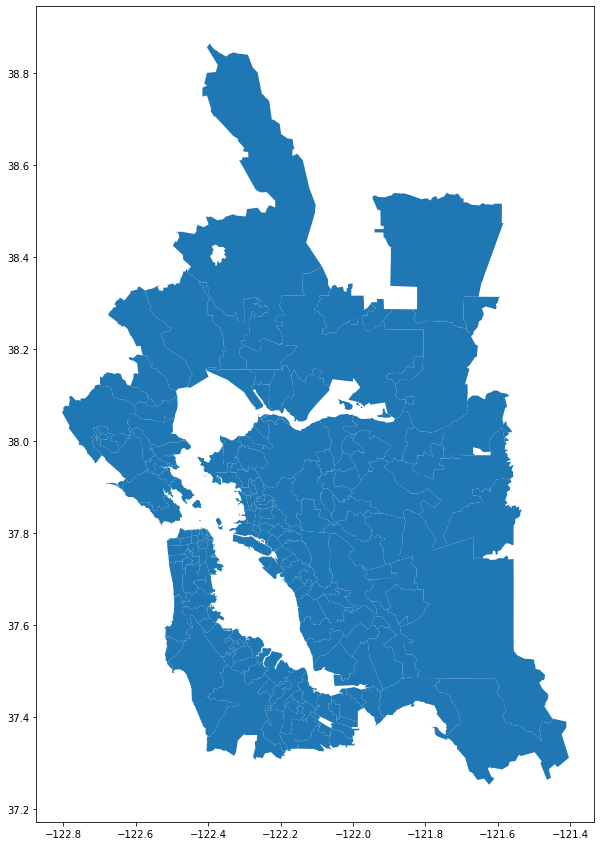

In [23]:
fig,ax = plt.subplots(figsize=(15,15))
bay_area_zips.plot(ax=ax)

In [228]:
#fig,ax = plt.subplots(figsize=(15,15))
#bay_area_counties.plot(ax=ax)
#bay_area_counties[bay_area_counties[bay_area_counties.COUNTY] == True].plot(ax=ax)

In [24]:
#fig,ax = plt.subplots(figsize=(15,15))
#bay_area.plot(ax=ax)
bay_area_zips.ZIP

0      94558
1      95620
2      95476
3      94559
4      94533
       ...  
182    94022
183    94085
184    94086
185    94024
186    94087
Name: ZIP, Length: 187, dtype: object

### Creating the GeoDataFrame

In [25]:
geometry = [Point(xy) for xy in zip(df["start_station_longitude"], df["start_station_latitude"])]

In [26]:
## Get all the data ready for the chart

geo_df = gpd.GeoDataFrame(df,
                          crs='EPSG:4326', ## CRS matches shape file (bay_area.crs)
                         geometry=geometry)
geo_df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method,covid,start_month,coordinates_nongeom2,start_date,geometry
0,83118,2020-01-31 15:23:47.733,2020-02-01 14:29:06.2630,400.0,Buchanan St at North Point St,37.804272,-122.433537,400.0,Buchanan St at North Point St,37.804272,-122.433537,13052,casual_rider,NaN,0,1,"(-122.4335369468, 37.8042720199)",2020-01-31,POINT (-122.43354 37.80427)
1,68239,2020-01-31 15:40:31.616,2020-02-01 10:37:51.0000,99.0,Folsom St at 15th St,37.767037,-122.415443,99.0,Folsom St at 15th St,37.767037,-122.415443,12235,annual_subscriber,NaN,0,1,"(-122.41544250000001, 37.7670373)",2020-01-31,POINT (-122.41544 37.76704)
2,55407,2020-01-31 17:48:16.635,2020-02-01 09:11:44.3170,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,12822,casual_rider,NaN,0,1,"(-122.24967990000002, 37.808847899999996)",2020-01-31,POINT (-122.24968 37.80885)
3,54929,2020-01-31 17:53:03.413,2020-02-01 09:08:32.6340,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,197.0,El Embarcadero at Grand Ave,37.808848,-122.249680,11705,casual_rider,NaN,0,1,"(-122.24967990000002, 37.808847899999996)",2020-01-31,POINT (-122.24968 37.80885)
4,55700,2020-01-31 17:12:33.460,2020-02-01 08:40:53.6460,12.0,Pier 1/2 at The Embarcadero,37.796389,-122.394586,371.0,Lombard St at Columbus Ave,37.802746,-122.413579,3673,casual_rider,NaN,0,1,"(-122.3945855, 37.796389399999995)",2020-01-31,POINT (-122.39459 37.79639)


In [28]:
geo_df_with_cities = gpd.sjoin(geo_df, bay_area_cities, how='inner', op ='within')
geo_df_with_cities

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,start_month,coordinates_nongeom2,start_date,geometry,index_right,city,county,source,ugb,acres
0,83118,2020-01-31 15:23:47.733,2020-02-01 14:29:06.2630,400.0,Buchanan St at North Point St,37.804272,-122.433537,400.0,Buchanan St at North Point St,37.804272,...,1,"(-122.4335369468, 37.8042720199)",2020-01-31,POINT (-122.43354 37.80427),100,SAN FRANCISCO,SAN FRANCISCO,TIGER,None,0.000000
1,68239,2020-01-31 15:40:31.616,2020-02-01 10:37:51.0000,99.0,Folsom St at 15th St,37.767037,-122.415443,99.0,Folsom St at 15th St,37.767037,...,1,"(-122.41544250000001, 37.7670373)",2020-01-31,POINT (-122.41544 37.76704),100,SAN FRANCISCO,SAN FRANCISCO,TIGER,None,0.000000
4,55700,2020-01-31 17:12:33.460,2020-02-01 08:40:53.6460,12.0,Pier 1/2 at The Embarcadero,37.796389,-122.394586,371.0,Lombard St at Columbus Ave,37.802746,...,1,"(-122.3945855, 37.796389399999995)",2020-01-31,POINT (-122.39459 37.79639),100,SAN FRANCISCO,SAN FRANCISCO,TIGER,None,0.000000
5,11333,2020-01-31 22:48:22.639,2020-02-01 01:57:15.7160,60.0,8th St at Ringold St,37.774520,-122.409449,75.0,Market St at Franklin St,37.773793,...,1,"(-122.40944936870001, 37.7745204011)",2020-01-31,POINT (-122.40945 37.77452),100,SAN FRANCISCO,SAN FRANCISCO,TIGER,None,0.000000
6,11341,2020-01-31 22:48:12.989,2020-02-01 01:57:14.1650,60.0,8th St at Ringold St,37.774520,-122.409449,75.0,Market St at Franklin St,37.773793,...,1,"(-122.40944936870001, 37.7745204011)",2020-01-31,POINT (-122.40945 37.77452),100,SAN FRANCISCO,SAN FRANCISCO,TIGER,None,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794050,969,2020-03-16 22:07:52.000,2020-03-16 22:24:01,NaN,NaN,37.325513,-121.949650,NaN,NaN,37.294340,...,3,"(-121.9496495, 37.325512833299996)",2020-03-16,POINT (-121.94965 37.32551),82,SANTA CLARA,SANTA CLARA,Santa Clara County Planning Office,None,11644.209588
794091,548,2020-03-06 17:45:21.000,2020-03-06 17:54:30,NaN,NaN,37.325633,-121.950023,NaN,NaN,37.315979,...,3,"(-121.9500233333, 37.325633)",2020-03-06,POINT (-121.95002 37.32563),82,SANTA CLARA,SANTA CLARA,Santa Clara County Planning Office,None,11644.209588
808889,328,2020-03-16 17:08:20.000,2020-03-16 17:13:49,NaN,NaN,37.706875,-122.414440,NaN,NaN,37.707359,...,3,"(-122.4144405, 37.7068748333)",2020-03-16,POINT (-122.41444 37.70687),21,DALY CITY,SAN MATEO,San Mateo County GIS,None,4881.245028
808890,878,2020-03-28 18:04:14.000,2020-03-28 18:18:53,NaN,NaN,37.706876,-122.414365,NaN,NaN,37.720756,...,3,"(-122.4143648333, 37.706875833299996)",2020-03-28,POINT (-122.41436 37.70688),21,DALY CITY,SAN MATEO,San Mateo County GIS,None,4881.245028


In [29]:
## Get the count of rides by city by day and label it sensically

dfpivot = pd.pivot_table(geo_df_with_cities,index=['city', 'start_date'],values=['bike_id'],aggfunc={'bike_id':'count'})
dfpivot.reset_index(inplace=True)
dfpivot.rename({"bike_id": "count"}, axis='columns', inplace=True)
dfpivot.head()

,city,start_date,count
0,BERKELEY,2020-01-01,121
1,BERKELEY,2020-01-02,251
2,BERKELEY,2020-01-03,304
3,BERKELEY,2020-01-04,200
4,BERKELEY,2020-01-05,170


In [30]:
## Merge the counts back in with the geometric data

geo_df_with_counts = bay_area_cities.merge(dfpivot, how='inner',on='city')
geo_df_with_counts

,city,county,source,ugb,acres,geometry,start_date,count
0,BERKELEY,ALAMEDA,Alameda Community Development Agency,None,6732.247236,"POLYGON ((-122.31343 37.88110, -122.31258 37.8...",2020-01-01,121
1,BERKELEY,ALAMEDA,Alameda Community Development Agency,None,6732.247236,"POLYGON ((-122.31343 37.88110, -122.31258 37.8...",2020-01-02,251
2,BERKELEY,ALAMEDA,Alameda Community Development Agency,None,6732.247236,"POLYGON ((-122.31343 37.88110, -122.31258 37.8...",2020-01-03,304
3,BERKELEY,ALAMEDA,Alameda Community Development Agency,None,6732.247236,"POLYGON ((-122.31343 37.88110, -122.31258 37.8...",2020-01-04,200
4,BERKELEY,ALAMEDA,Alameda Community Development Agency,None,6732.247236,"POLYGON ((-122.31343 37.88110, -122.31258 37.8...",2020-01-05,170
...,...,...,...,...,...,...,...,...
535,SAN FRANCISCO,SAN FRANCISCO,TIGER,None,0.000000,"MULTIPOLYGON (((-122.36211 37.80703, -122.3624...",2020-03-28,1570
536,SAN FRANCISCO,SAN FRANCISCO,TIGER,None,0.000000,"MULTIPOLYGON (((-122.36211 37.80703, -122.3624...",2020-03-29,1436
537,SAN FRANCISCO,SAN FRANCISCO,TIGER,None,0.000000,"MULTIPOLYGON (((-122.36211 37.80703, -122.3624...",2020-03-30,1577
538,SAN FRANCISCO,SAN FRANCISCO,TIGER,None,0.000000,"MULTIPOLYGON (((-122.36211 37.80703, -122.3624...",2020-03-31,1652


In [31]:
## Test set to play around with loop before creating lots of things and having regrets

geo_df_test=geo_df_with_counts.head(10)
# max(geo_df_with_counts['count'])
geo_df_test_sf = geo_df_with_counts.loc[geo_df_with_counts['city']=='SAN FRANCISCO'].head(10)


AttributeError: 'PatchCollection' object has no property 'c'

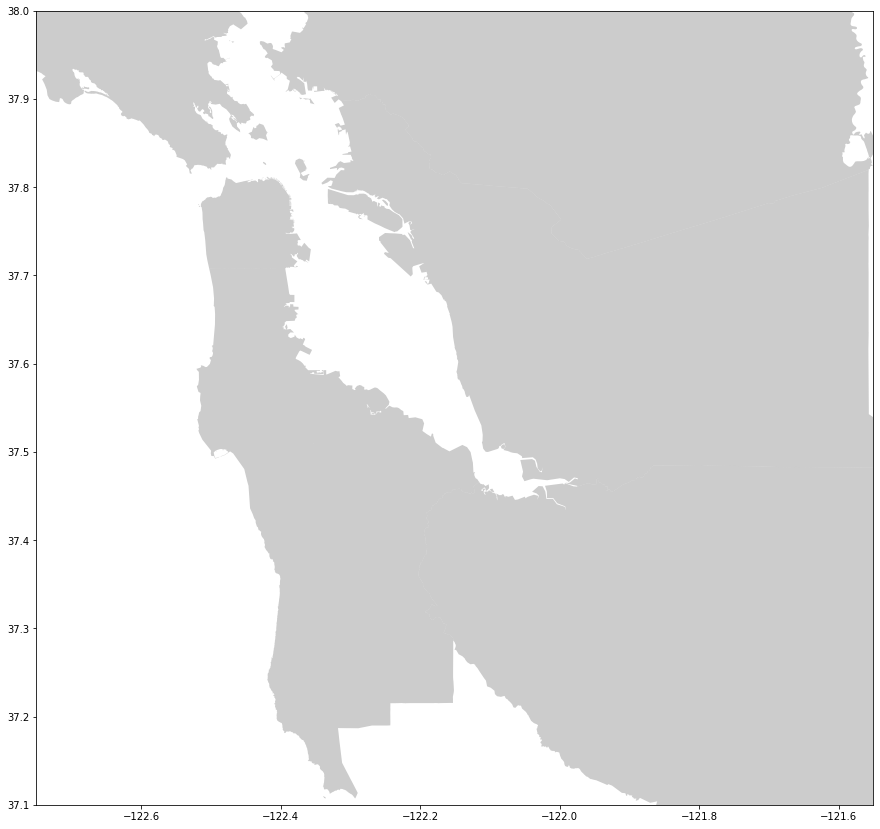

In [32]:

## It's the final countdown

#c sequence

#plot
#plt.scatter( wine_df['Alcohol'], wine_df['Color intensity'] , c=c, 
            #cmap = 'RdPu', s = wine_df['Proline']*.5, alpha =0.5)
#cbar = plt.colorbar()
#cbar.set_label('Color Intensity')


def print_map(x):
    for date in x['start_date']:
        c = x['count']
        geo_df_with_counts_day = x.loc[x['start_date']==date]
        fix,ax=plt.subplots(figsize=(15,15))
        norm=colors.LogNorm(vmin=min(x['count']), vmax=min(x['count']))
        ax.set(xlim=[-122.75,-121.55], ylim=[37.10,38.0], aspect=1)
        bay_area.plot(ax = ax, figsize=(15,15), alpha=0.4, color='grey')
        geo_df_with_counts_day.plot(ax = ax,c=c, cmap='cool')
        plt.title('BayWheels Rides '+str(date), fontsize=24, loc='center')
        cbar = plt.colorbar()
        cbar.set_label('Count of Rides')
        #fix.savefig('baywheels_'+ str(date) + '.png', facecolor='white', dpi=150, bbox_inches='tight')
        
x=geo_df_test_sf
print_map(x)
    

### Creating Final Visualization

In [1067]:
## for each date in the range
## get those dates in a geodataframe
## plot it
## save as png

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

def output_images():
    i = 0
    for date in date_rng:
        fig, ax = plt.subplots(figsize=(18, 6))

        world.plot(
            ax=ax,
            color = "lightslategray", 
            edgecolor = "slategray", 
            linewidth = 0.5);

        ax.axis('off')

        d = date
        ax.set_title(d.strftime("%b %d %Y"))
        day_df = build_df_for_datetime(d)
        ncov = build_ncov_geodf(day_df)

        ncov.plot(
            ax=ax, 
            column='Confirmed', 
            norm=colors.LogNorm(vmin=1, vmax=1000),
            legend=True,
            legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
            cmap='OrRd')

        i += 1
        fig.savefig('./out/' + '{0:03d}'.format(i) + '.png', facecolor='slategrey', dpi=150, bbox_inches='tight')


Text(0.5, 1, 'BayWheels Initiated Rides Q1 2020')

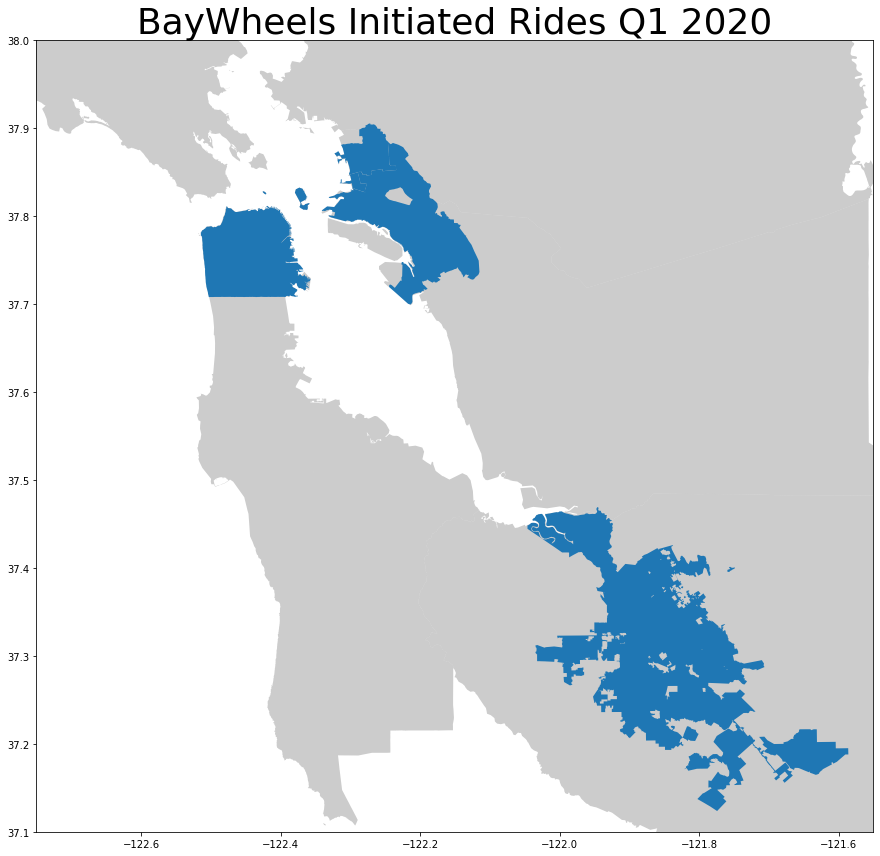

In [1429]:
## Creating final plot
fix,ax=plt.subplots(figsize=(15,15))
ax.set(xlim=[-122.75,-121.55], ylim=[37.10,38.0], aspect=1)
bay_area.plot(ax = ax, figsize=(15,15), alpha=0.4, color='grey')
geo_df_with_counts_jan1.plot(ax = ax)
plt.title('BayWheels Initiated Rides Q1 2020', fontsize=36, loc='center')

## Sources

_This information, particularly the tutorials and guides on `Medium`, were instrumental in this project_

#### Medium Articles
1. Importing CSVs: https://medium.com/@kadek/elegantly-reading-multiple-csvs-into-pandas-e1a76843b688
2. Time lapse display: https://medium.com/@tyreus/visualizing-the-spread-of-the-2019-coronavirus-with-python-7e63230f9505
3. GeoPandas Plotting:      https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

#### Primary Sources
4. Bike Data:      https://s3.amazonaws.com/baywheels-data/index.html
5. Shape Files:    https://geodata.lib.berkeley.edu/?bbox=-127.749023+29.036961+-112.412109+45.675482&f%5Bdc_format_s%5D%5B%5D=Shapefile&f%5Bdct_spatial_sm%5D%5B%5D=San+Francisco+Bay+Area+%28Calif.%29&per_page=10

#### Formal Documentation
6. Pandas:         https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
7. GeoPanda Documentation: https://geopandas.org/reference.html
8. Matplotlib Colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html

#### Historical Context
8. Bay Wheels Feb Price Increase: https://mashable.com/article/lyft-bay-wheels-ebike-price-increase/
9. COVID Timeline in Bay Area: https://abc7news.com/timeline-of-coronavirus-us-coronvirus-bay-area-sf/6047519/